## Dependances installation and imports

This notebook illustrates how to use Xplique on Detection models. Here we show its usage on a RetinaNet Model from Google's Model Garden (https://github.com/tensorflow/models) train on Coco.

- First, install the corresponding package, tf-models-official.
    - Uncomment the following line if you do not have it installed already :

In [2]:
#! python -m pip install tf-models-official

- We import all the external dependancies :

In [3]:
import tensorflow as tf
import yaml
import os
import dataclasses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from official.vision.modeling.heads.dense_prediction_heads import RetinaNetHead
from official.vision.serving import detection
from official.core.config_definitions import ExperimentConfig, TaskConfig, TrainerConfig, RuntimeConfig, base_config
from official.vision.configs import retinanet
from official.vision.tasks import RetinaNetTask

C:\Users\maxime.carrere\PycharmProjects\xplique\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


- We download the trained weights and configuration of the Retinanet detection model :

In [4]:
os.makedirs("models/retinanet", exist_ok=True)
if not os.path.exists("models/retinanet/retinanet-resnet50fpn.tar.gz"):
    ! wget https://storage.googleapis.com/tf_model_garden/vision/retinanet/retinanet-resnet50fpn.tar.gz -P models/retinanet
    ! tar -xf models/retinanet/retinanet-resnet50fpn.tar.gz -C models/retinanet
if not os.path.exists("models/retinanet/resnet50fpn_coco_tfds_tpu.yaml"):
    ! wget https://github.com/tensorflow/models/raw/r2.8.0/official/vision/beta/configs/experiments/retinanet/resnet50fpn_coco_tfds_tpu.yaml -P models/retinanet

- Let's load our retinanet model :

In [5]:
# parse the configuration file
pipeline_config = "models/retinanet/resnet50fpn_coco_tfds_tpu.yaml"
with tf.io.gfile.GFile(pipeline_config, 'r') as yaml_file:
    yaml_string = yaml_file.read()
model_yaml = yaml.safe_load(yaml_string)

# Instanciate the configuration it as a dataclass strcuture, as required by tf-models-official.
@dataclasses.dataclass
class RetinanetExperimentConfig(base_config.Config):
    task: TaskConfig = retinanet.RetinaNetTask()
    trainer: TrainerConfig = TrainerConfig()
    runtime: RuntimeConfig = RuntimeConfig()

# Build architecture described in the configuration, and load the trained weights.
cfg = RetinanetExperimentConfig.from_yaml(pipeline_config)
cfg.runtime.distribution_strategy = "gpu"
cfg.task.model.num_classes = 91 #80: 819, 720
det = detection.DetectionModule(cfg, batch_size=1, input_image_size=[384, 384])
ckpt = tf.compat.v2.train.Checkpoint(model=det.model)
print(ckpt.restore("models/retinanet/ckpt-33264").expect_partial())

## Inference with the detection model

- Let's apply our model on an image :

In [39]:
x1 = np.expand_dims(tf.keras.preprocessing.image.load_img("zidane.jpg", target_size=(384, 384)), 0)
x2 = np.expand_dims(tf.keras.preprocessing.image.load_img("cat.png", target_size=(384, 384)), 0)
x = np.concatenate([x1,x2], axis=0,dtype=np.float32)
res = det.serve(x2)

- and display its result :

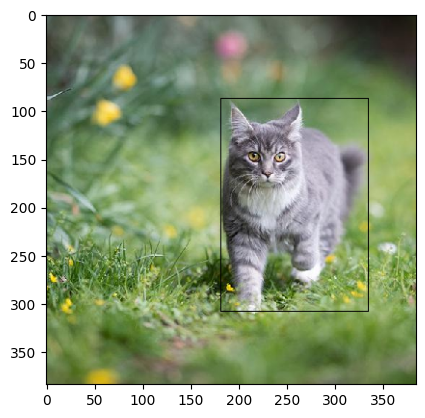

In [40]:
%matplotlib inline
mim_res = np.array(x[1])
bbox = np.array(res["detection_boxes"][0][0], dtype=np.int32)
cv2.rectangle(im_res, 
              (bbox[1],bbox[0]), (bbox[3],bbox[2]),
              color=(0,0,0))
plt.imshow(np.array(im_res, dtype=np.uint8))

- Check the predicted classes : # todo : include it in the visu

In [8]:
label = np.array(res["detection_classes"][0][0], dtype=np.int32)

In [9]:
coco = pd.read_csv("./coco-labels-91.txt", header=None)

In [10]:
coco.iloc[label-1]

0    cat
Name: 16, dtype: object

## Explaining the detection result with Xplique

Depending on the detection dataset and use case, the bounding box (bbox) format, classes encoding, often differs. 
 - For example, the output of our Retinanet detection module is a Python dict, with one value the tensor with the bbox positions, one with the bbox classes (ordinal encoding), and one with the bbox score. 
Thus, we need to make our model compatible with the format expected by Xplique.
    - Xplique expect the following format for detection results :
        [batch_size, nb_bboxes, nb_classes+5]
        - the first dimension is the batch dimension
        - second is the number of bbox per image.
        - third is [x, y, x, y, conf, one_hot_cls]: 
                - the first 4 values are the bbox coordinates in xyxy format (xy top left, xy bottom right)
                - conf is the confidence score of the bbox
                - one_hot_cls is a one hot encoding of the bbox classe.

In [33]:
import tensorflow as tf

class ModelWrapper():
    def __init__(self, model):
        self.model = model
        
    def __call__(self, x):
        preds = self.model.serve(x)
        return self.get_boxes_constant_size_map(preds)

    
    @staticmethod
    def get_boxes_constant_size_map(preds, nb_classes=91):
        preds= tf.concat([tf.expand_dims(preds["detection_boxes"][...,0], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,2], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,1], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,3], axis=-1),
                          tf.expand_dims(preds["detection_scores"], axis=-1), 
                          tf.expand_dims(tf.cast(preds["detection_classes"], tf.float32), axis=-1)], axis=-1)
        def pred_loop(pred):
            boxes = pred[..., :4] 
            scores = pred[..., 4]
            cls = pred[..., 5]
            one_hot_cls = tf.cast(tf.one_hot(tf.cast(cls, tf.int32), nb_classes, 1), tf.float32)

            results = tf.concat([boxes, tf.expand_dims(scores, axis=-1),
                       one_hot_cls], axis=-1)
            return results
        batch_results = tf.map_fn(pred_loop, preds, infer_shape=False)
        return batch_results

    @property
    def layers(self):
        return self.model.layers

    @property
    def input(self):
        return self.model.input

    @property
    def output(self):
        return self.model.output

    @staticmethod
    def from_config(conf_wrapper):
        model_wrapper = conf_wrapper["model_wrapper"]
        config = conf_wrapper["config"]
        keras_model = model_wrapper.model.__class__.from_config(config)
        keras_model.decode_predictions = model_wrapper.model.decode_predictions
        return ModelWrapper(keras_model, model_wrapper.HEIGHT, model_wrapper.WIDTH,
                            model_wrapper.nb_classes, model_wrapper.threshold)

    def get_config(self):
        return {"config": self.model.get_config(), "model_wrapper": self}

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        return self.model.set_weights(weights)

In [34]:
import os
from pathlib import Path
import numpy as np

from xplique.attributions import SobolAttributionMethod
from xplique.attributions import IntegratedGradients
from xplique.attributions import SmoothGrad, Saliency, DeconvNet, GradientInput, GuidedBackprop
from object_detector import BoxIouCalculator,ImageObjectDetectorScoreCalculator, YoloObjectFormater

import matplotlib.pyplot as plt
from xplique.plots.image import _normalize, _clip_percentile
from xplique.metrics import Deletion, Insertion, MuFidelity, AverageStability

class Explainer:
    methods = {
        "ig":IntegratedGradients,
        "saliency":Saliency,
        "deconvnet":DeconvNet,
        "gradient_input":GradientInput,
        "guided_backprop": GuidedBackprop,
        "sobol": SobolAttributionMethod,
        "smoothgrad": SmoothGrad
    }
    metrics = {
        "deletion": Deletion,
        "insertion": Insertion,
        "mufidelity": MuFidelity,
        "average_stability": AverageStability
    }
    def __init__(self, model, nb_classes=20):
        self.model = model
        self.score_calculator = ImageObjectDetectorScoreCalculator(
            YoloObjectFormater(), BoxIouCalculator())
        self.explainer_wrapper = None
        self.nb_classes = nb_classes
        self.last_params = None

    def apply(self, method_name, preds, img, params):
        self.last_params = params.copy()
        self.last_img = img
        wrapper = ModelWrapper(self.model, img.shape[1], img.shape[2], self.nb_classes)
        self.last_params["operator"] = self.score_calculator.tf_batched_score
        self.explainer_wrapper = self.methods[method_name](wrapper, **self.last_params)
        self.last_expl = self.explainer_wrapper.explain(img, wrapper.get_boxes_constant_size_map(preds))
        self.last_params["method"] = method_name
        return self.last_expl

    def score(self, method, explanation, img, preds, params={}):
        wrapper = ModelWrapper(self.model, img.shape[1], explanation.shape[2], self.nb_classes)
        #operator_batched = operator_batching()
        if method != "average_stability":
            params["operator"] = self.score_calculator.tf_batched_score
            metric = self.metrics[method](wrapper, np.array(img), wrapper.get_boxes_constant_size_map(preds), **params)
            return metric(explanation)

        metric = self.metrics[method](wrapper, np.array(img), wrapper.get_boxes(preds), **params)
        return metric(self.explainer_wrapper)

    def visualize(self, alpha=0.5, cmap="jet", clip_percentile=0.5, figsize=(10,10)):
        image = self.last_img[-1]
        expl = self.last_expl[-1]
        plt.figure(figsize=figsize)
        if image is not None:
            image = _normalize(image)
            plt.imshow(image)
        if expl.shape[-1] == 3:
            expl = np.mean(expl, -1)
        if clip_percentile:
            expl = _clip_percentile(expl, clip_percentile)
        if not np.isnan(np.max(np.min(expl))):
            expl = _normalize(expl)

        plt.imshow(expl, cmap=cmap, alpha=alpha)
        plt.axis('off')

In [35]:
explainer = Explainer(det)

boxes_refs (100, None, 4)
class_refs (100, None, 91)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
batch shape TensorShape([16, 384, 384, 3])
printing output------------
[16 100 96]
[87.9244232 308.154785 181.02002 ... 0 0 0]
Before batch loop
images_score TensorShape([None])
batch shape TensorShape([16, 384, 384, 3])
printing output------------
[16 100 96]
[87.9204559 308.131775 181.016724 ... 0 0 0]
Before batch loop
images_score TensorShape([None])
batch shape TensorShape([16, 384, 384, 3])
printing output------------
[16 100 96]
[87.9306488 308.138916 181.038864 ... 0 0 0]
Before batch loop
images_score TensorShape([None])
boxes_refs (100, None, 4)
class_refs (100, None, 91)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
batch shape TensorShape([2, 384, 384, 3])
printing output------------
[2 100 96]
[87.9

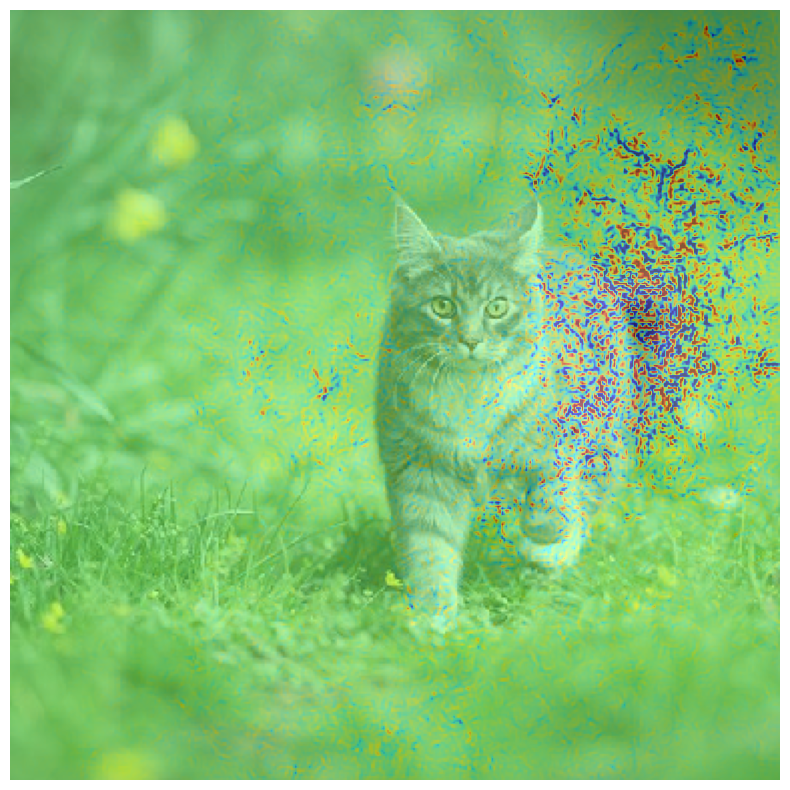

In [36]:
"""
method = "sobol"
params = {
    "batch_size": 16,
    "grid_size":16,
    "nb_design":32
}"""
"""
method = "saliency"
params = {
    "batch_size": 16
}"""

method = "smoothgrad"
params = {
    "batch_size": 16,
    "nb_samples": 50,
    "noise": 0.069
}
# only keep the first bbox, rest is empty.
res["detection_boxes"] = np.array(res["detection_boxes"])
res["detection_boxes"][0,1:,:] = 0
res["detection_scores"] = np.array(res["detection_scores"])
res["detection_scores"][0,1:] = 0
res["detection_classes"] = np.array(res["detection_classes"])
res["detection_classes"][0,1:] = 0
explanation = explainer.apply(method, res, x2, params)
explainer.visualize()
plt.show()

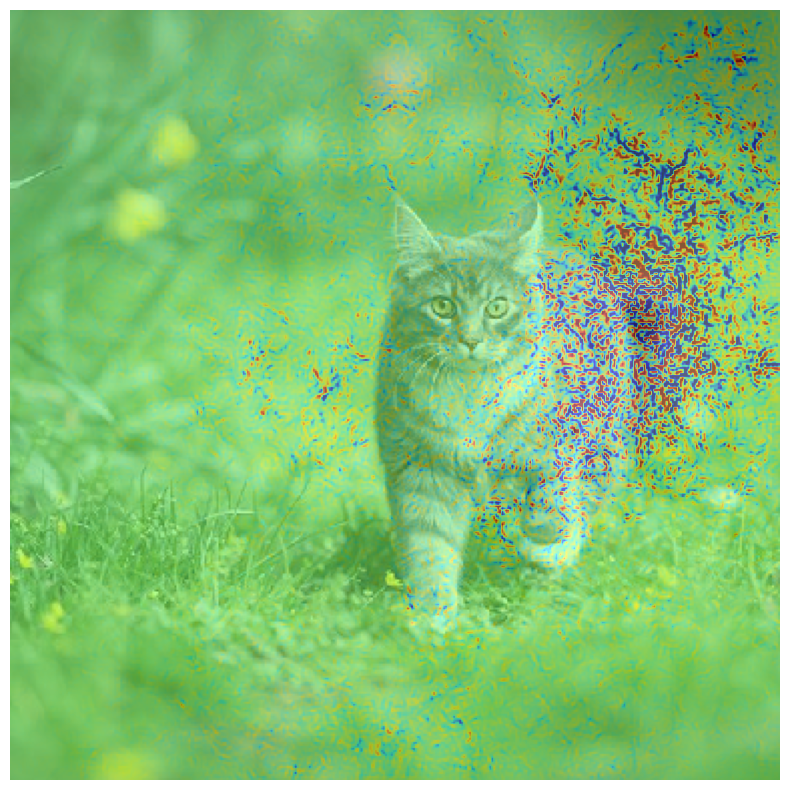

In [37]:
explainer.visualize(clip_percentile=0.9)

In [ ]:
"""
for method in explainer.methods.keys():
    params = {
        "batch_size":16
    }
    
    explanation = explainer.apply(method, res, x2, params)
    explainer.visualize()
"""

In [21]:
explainer.score("deletion", explanation, x2, res, {"batch_size":16, "steps":30,"max_percentage_perturbed":0.5})

batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[87.9228363 308.147705 181.022247 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (100, 100)
ref_boxes_scores (100,)
image_score ()
images_score TensorShape([1])
batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[86.9640427 312.272644 181.193619 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (100, 100)
ref_boxes_scores (100,)
image_score ()
images_score TensorShape([1])
batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[85.9367676 317.003265 181.837189 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (10

batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[0.986557 379.432861 73.5378723 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (100, 100)
ref_boxes_scores (100,)
image_score ()
images_score TensorShape([1])
batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[1.0712738 383.160767 53.9042358 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (100, 100)
ref_boxes_scores (100,)
image_score ()
images_score TensorShape([1])
batch shape TensorShape([1, 384, 384, 3])
printing output------------
[1 100 96]
[2.60849 383.332611 57.9448853 ... 0 0 0]
Before batch loop
boxes_refs (100, 100, 4)
class_refs (100, 100, 91)
classification_similarity (100, 100)
proba_detection (100, 1)
boxes_pairwise_scores (100, 100

0.00039990193909034133

In [15]:
explainer.score_calculator.tf_batched_score

<bound method ImageObjectDetectorScoreCalculator.tf_batched_score of <object_detector.ImageObjectDetectorScoreCalculator object at 0x0000027638FFCF10>>